Feature Datagram : (657, 10)


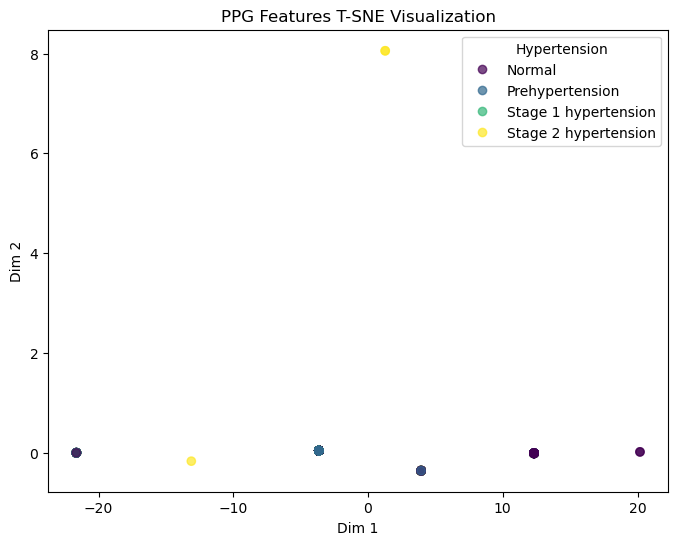

C:\ProgramData\anaconda33\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


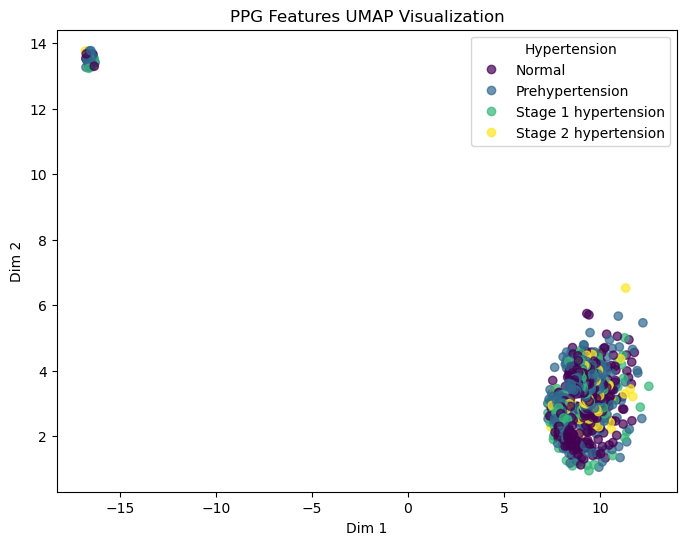

   subject_ID          Hypertension  MeanBBI      SDNN     RMSSD  pNN50  \
0           2  Stage 2 hypertension  0.34375  0.025584  0.027805    0.0   
1           2  Stage 2 hypertension  0.34375  0.025584  0.027805    0.0   
2           2  Stage 2 hypertension  0.34375  0.025584  0.027805    0.0   
3           3  Stage 2 hypertension  0.34375  0.025584  0.027805    0.0   
4           3  Stage 2 hypertension  0.34375  0.025584  0.027805    0.0   

        SD1       SD2      ApEn     SampEn  
0  0.019661  0.030343 -0.682082 -22.848983  
1  0.019661  0.030343 -0.682082 -22.848983  
2  0.019661  0.030343 -0.682082 -22.848983  
3  0.019661  0.030343 -0.682082 -22.848983  
4  0.019661  0.030343 -0.682082 -22.848983  


In [1]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import pandas as pd
import numpy as np
from scipy.signal import find_peaks, welch
from scipy.integrate import simpson
from scipy.interpolate import interp1d
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import scipy.stats as stats

# UMAP 설치 여부 확인
try:
    import umap
except ModuleNotFoundError:
    umap = None
    print("경고: umap-learn 라이브러리가 설치되지 않았습니다. `pip install umap-learn` 실행 후 다시 시도하세요.")

# --- 비선형 지표 함수들 ---
def approximate_entropy(x, m=2, r=None):
    x = np.asarray(x)
    if x.ndim != 1:
        raise ValueError("입력은 1차원 시퀀스여야 합니다.")
    if r is None:
        r = 0.2 * np.std(x) if len(x)>0 else 0.0
    N = len(x)
    if N <= m:
        return np.nan
    def _phi(m_):
        xm = np.array([x[i:i + m_] for i in range(N - m_ + 1)])
        diff = np.abs(xm[:, None, :] - xm[None, :, :])
        max_diff = np.max(diff, axis=2)
        C = np.sum(max_diff <= r, axis=0) / (N - m_ + 1)
        return np.mean(np.log(np.maximum(C, 1e-10)))
    return _phi(m) - _phi(m + 1)

def sample_entropy(x, m=2, r=None):
    x = np.asarray(x)
    if x.ndim != 1:
        raise ValueError("Input must be a 1D sequence.")
    if r is None:
        r = 0.2 * np.std(x) if len(x)>0 else 0.0
    N = len(x)
    if N <= m:
        return np.nan
    def _count_matches(m_):
        xm = np.array([x[i:i + m_] for i in range(N - m_ + 1)])
        diff = np.abs(xm[:, None, :] - xm[None, :, :])
        max_diff = np.max(diff, axis=2)
        mask = np.ones(max_diff.shape, bool)
        np.fill_diagonal(mask, False)
        num = np.sum(max_diff[mask] <= r)
        den = (N - m_ + 1) * (N - m_)
        return num, den
    num_m, den_m = _count_matches(m)
    num_m1, den_m1 = _count_matches(m + 1)
    if den_m == 0 or den_m1 == 0 or num_m == 0 or num_m1 == 0:
        return -np.log(((num_m1 + 1e-10)/(den_m1 + 1e-10)) / ((num_m + 1e-10)/(den_m + 1e-10)))
    return -np.log((num_m1/den_m1)/(num_m/den_m))

def dfa(x, min_win=4, max_win=None):
    x = np.asarray(x)
    N = len(x)
    max_win = N//4 if max_win is None else min(max_win, N)
    if N < min_win*2:
        return np.nan, np.nan
    Y = np.cumsum(x - np.mean(x))
    ws = np.unique(np.floor(np.logspace(np.log10(min_win), np.log10(max_win), num=20)).astype(int))
    ws = ws[ws*2 <= N]
    if len(ws) < 2:
        return np.nan, np.nan
    F_vals, valid_ws = [], []
    for w in ws:
        segs = N//w
        rms = []
        for i in range(segs):
            seg = Y[i*w:(i+1)*w]
            t = np.arange(w)
            try:
                coef = np.polyfit(t, seg, 1)
                trend = np.polyval(coef, t)
                rms.append(np.sqrt(np.mean((seg - trend)**2)))
            except:
                continue
        if rms:
            F_vals.append(np.sqrt(np.mean(np.array(rms)**2)))
            valid_ws.append(w)
    if len(F_vals) < 2:
        return np.nan, np.nan
    log_w = np.log(valid_ws)
    log_F = np.log(F_vals)
    a1 = stats.linregress(log_w[np.array(valid_ws)<16], log_F[np.array(valid_ws)<16]).slope if np.sum(np.array(valid_ws)<16)>=2 else np.nan
    a2 = stats.linregress(log_w[np.array(valid_ws)>=16], log_F[np.array(valid_ws)>=16]).slope if np.sum(np.array(valid_ws)>=16)>=2 else np.nan
    return a1, a2

# 설정
FS = 1000  # 원본 샘플링 주파수
LABEL = 'Hypertension'
INTERP_FS = 4.0

# 데이터 로드

PATH = 'E:/dataset/Hypertension/Guilin_University/combined_dataset.xlsx'
df = pd.read_excel(PATH)
signal_cols = [str(i) for i in range(15, 2015)]
records = []
for _, row in df.iterrows():
    sid = row.get('subject_ID', row.get('SubjectID', f'Row'))
    sig = row[signal_cols].astype(float).values
    if len(sig) < FS*2 or not np.all(np.isfinite(sig)):
        continue
    peaks, _ = find_peaks(sig, distance=int((60/300)*FS), height=np.quantile(sig, 0.1))
    if len(peaks) < 5:
        continue
    bbi = np.diff(peaks)/FS
    bbi = bbi[(bbi>0.3)&(bbi<2.0)]
    # PRV
    if len(bbi) < 4:
        lf=hf=tp=lf_hf=lf_nu=hf_nu=np.nan
        mean_bbi=sdnn=rmssd=pnn50=np.nan
        sd1=sd2=np.nan
    else:
        try:
            cumsum = np.cumsum(bbi)
            starts = np.concatenate(([0], cumsum[:-1]))
            interp_func = interp1d(starts, bbi, kind='cubic', fill_value='extrapolate')
            t_new = np.arange(starts[0], cumsum[-1], 1/INTERP_FS)
            bbi_i = interp_func(t_new)
            nperseg = min(len(bbi_i), 256)
            if len(bbi_i) > nperseg:
                f, P = welch(bbi_i, fs=INTERP_FS, nperseg=nperseg)
                lf = simpson(P[(f>=0.04)&(f<0.15)], f[(f>=0.04)&(f<0.15)])
                hf = simpson(P[(f>=0.15)&(f<0.4)], f[(f>=0.15)&(f<0.4)])
                vlf = simpson(P[f<0.04], f[f<0.04])
                tp = simpson(P[f<0.4], f[f<0.4])
                lf_hf = lf/hf if hf>0 else np.nan
                tp_vlf = tp - vlf
                lf_nu = lf/tp_vlf if tp_vlf>0 else np.nan
                hf_nu = hf/tp_vlf if tp_vlf>0 else np.nan
            else:
                lf=hf=tp=lf_hf=lf_nu=hf_nu=np.nan
        except:
            lf=hf=tp=lf_hf=lf_nu=hf_nu=np.nan
        mean_bbi = np.mean(bbi) if bbi.size>0 else np.nan
        sdnn = np.std(bbi, ddof=1) if bbi.size>1 else np.nan
        diff_bbi = np.diff(bbi)
        rmssd = np.sqrt(np.mean(diff_bbi**2)) if diff_bbi.size>0 else np.nan
        pnn50 = np.sum(np.abs(diff_bbi)>0.05)/len(diff_bbi)*100 if diff_bbi.size>0 else np.nan
        sd1 = np.sqrt(0.5*rmssd**2) if not np.isnan(rmssd) else np.nan
        sd2 = np.sqrt(max(2*sdnn**2 - 0.5*rmssd**2, 0)) if not np.isnan(sdnn) else np.nan
    apen = approximate_entropy(bbi)
    sampen = sample_entropy(bbi)
    dfa1, dfa2 = dfa(bbi)
    records.append({
        'subject_ID': sid, LABEL: row.get(LABEL),
        'LF':lf, 'HF':hf, 'LF/HF':lf_hf, 'TP':tp, 'LFnu':lf_nu, 'HFnu':hf_nu,
        'MeanBBI':mean_bbi, 'SDNN':sdnn, 'RMSSD':rmssd, 'pNN50':pnn50,
        'SD1':sd1, 'SD2':sd2,
        'ApEn':apen, 'SampEn':sampen, 'DFA1':dfa1, 'DFA2':dfa2
    })
    
feat_df = pd.DataFrame(records)
feat_df.replace([np.inf, -np.inf], np.nan, inplace=True)
feat_df.dropna(axis=1, how='all', inplace=True)
numeric_cols = feat_df.columns.drop(['subject_ID', LABEL])
feat_df[numeric_cols] = feat_df[numeric_cols].apply(lambda c: c.fillna(c.mean()), axis=0)

print("Feature Datagram :", feat_df.shape)

# T-SNE 시각화
if not feat_df.empty:
    X = feat_df[numeric_cols].values
    label_cat = pd.Categorical(feat_df[LABEL])
    codes = label_cat.codes
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X)-1), n_iter=300)
    X2 = tsne.fit_transform(X)
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(X2[:,0], X2[:,1], c=codes, cmap='viridis', alpha=0.7)
    handles, _ = scatter.legend_elements()
    plt.legend(handles, label_cat.categories, title=LABEL)
    plt.title('PPG Features T-SNE Visualization')
    plt.xlabel('Dim 1')
    plt.ylabel('Dim 2')
    plt.show()
    
# UMAP 시각화
if umap and not feat_df.empty:
    X = feat_df[numeric_cols].values
    label_cat = pd.Categorical(feat_df[LABEL])
    codes = label_cat.codes
    um = umap.UMAP(n_components=2, random_state=42,
                   n_neighbors=min(15, len(X)-1), min_dist=0.1)
    Xu = um.fit_transform(X)
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(Xu[:,0], Xu[:,1], c=codes, cmap='viridis', alpha=0.7)
    handles, _ = scatter.legend_elements()
    plt.legend(handles, label_cat.categories, title=LABEL)
    plt.title('PPG Features UMAP Visualization')
    plt.xlabel('Dim 1')
    plt.ylabel('Dim 2')
    plt.show()
print(feat_df.head())

In [2]:
feat_df

,subject_ID,Hypertension,MeanBBI,SDNN,RMSSD,pNN50,SD1,SD2,ApEn,SampEn
0,2,Stage 2 hypertension,0.34375,0.025584,0.027805,0.0,0.019661,0.030343,-0.682082,-22.848983
1,2,Stage 2 hypertension,0.34375,0.025584,0.027805,0.0,0.019661,0.030343,-0.682082,-22.848983
2,2,Stage 2 hypertension,0.34375,0.025584,0.027805,0.0,0.019661,0.030343,-0.682082,-22.848983
3,3,Stage 2 hypertension,0.34375,0.025584,0.027805,0.0,0.019661,0.030343,-0.682082,-22.848983
4,3,Stage 2 hypertension,0.34375,0.025584,0.027805,0.0,0.019661,0.030343,-0.682082,-22.848983
...,...,...,...,...,...,...,...,...,...,...
652,418,Normal,0.34375,0.025584,0.027805,0.0,0.019661,0.030343,-0.682082,-22.848983
653,418,Normal,0.34375,0.025584,0.027805,0.0,0.019661,0.030343,-0.682082,-22.848983
654,419,Normal,0.34375,0.025584,0.027805,0.0,0.019661,0.030343,-0.682082,-22.848983
655,419,Normal,0.34375,0.025584,0.027805,0.0,0.019661,0.030343,-0.682082,-22.848983


In [3]:
feat_df.columns

Index(['subject_ID', 'Hypertension', 'MeanBBI', 'SDNN', 'RMSSD', 'pNN50',
       'SD1', 'SD2', 'ApEn', 'SampEn'],
      dtype='object')


설명된 분산 비율 (주성분1, 주성분2): [0.71428571 0.28571429]
두 주성분에 의해 설명되는 총 분산 비율: 100.00%


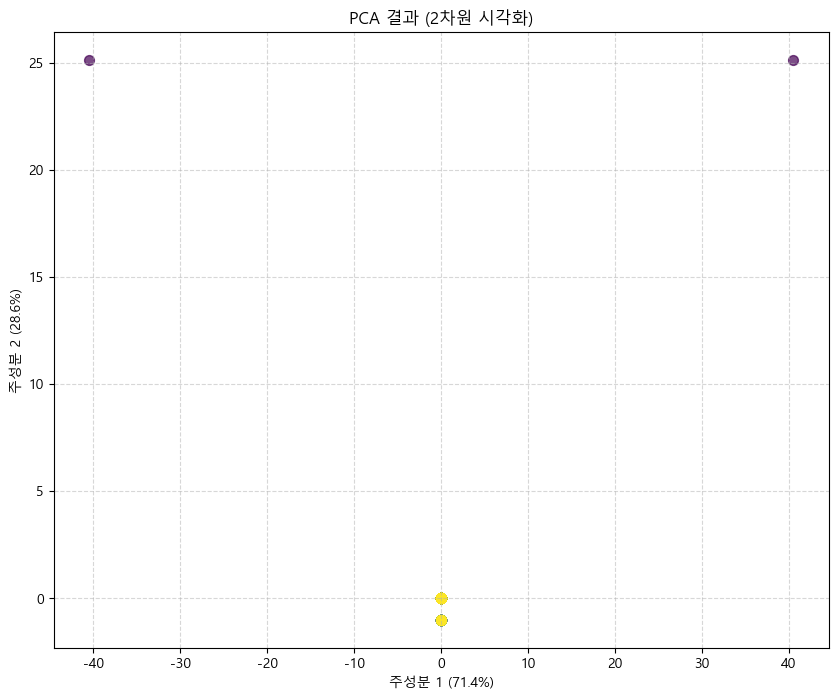

In [6]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler # 데이터 표준화를 위해 추가
import matplotlib.pyplot as plt
import matplotlib.cm as cm # 컬러맵 사용을 위해 추가

# --- 0. 데이터 준비 (이 부분은 이미 feat_df가 있다고 가정) ---
# 예시 데이터프레임 생성 (실제로는 이미 로드된 feat_df 사용)
# 아래 코드는 설명을 위해 임시로 생성하는 부분이므로, 실제 코드에서는 feat_df가 이미 있어야 합니다.
# ---------------------------------------------------------------
# data = {
#     'subject_ID': [f'S{i+1}' for i in range(100)],
#     'Hypertension': np.random.randint(0, 2, 100), # 0: 정상, 1: 고혈압 (예시)
#     'MeanBBI': np.random.rand(100) * 0.5 + 0.7,
#     'SDNN': np.random.rand(100) * 50 + 20,
#     'RMSSD': np.random.rand(100) * 30 + 10,
#     'pNN50': np.random.rand(100) * 20,
#     'SD1': np.random.rand(100) * 20 + 5,
#     'SD2': np.random.rand(100) * 40 + 15,
#     'ApEn': np.random.rand(100) * 0.5 + 0.8,
#     'SampEn': np.random.rand(100) * 0.6 + 0.7
# }
# feat_df = pd.DataFrame(data)
# print("예시 데이터프레임 정보:")
# print(feat_df.info())
# print(feat_df.head())
# ---------------------------------------------------------------
# 이 지점에서 'feat_df' 변수에 실제 데이터프레임이 할당되어 있어야 합니다.

# --- 1. 특징 및 레이블 선택 ---
# PCA 분석에 사용할 숫자형 특징 컬럼 목록
feature_cols = ['MeanBBI', 'SDNN', 'RMSSD', 'pNN50', 'SD1', 'SD2', 'ApEn', 'SampEn']
# 점의 색상을 구분할 기준이 되는 레이블 컬럼
label_col = 'Hypertension'

# 특징 데이터(X)와 레이블(y) 분리
# 대상 컬럼들이 feat_df에 있는지 확인
missing_features = [col for col in feature_cols if col not in feat_df.columns]
if missing_features:
    raise ValueError(f"데이터프레임에 다음 특징 컬럼이 없습니다: {missing_features}")
if label_col not in feat_df.columns:
    raise ValueError(f"데이터프레임에 레이블 컬럼 '{label_col}'이(가) 없습니다.")

# 결측치 확인 및 처리 (이전 코드에서 평균값으로 채웠다고 가정, 만약을 위해 확인)
if feat_df[feature_cols].isnull().values.any():
    print("경고: 특징 데이터에 결측치(NaN)가 있습니다. PCA 수행 전 처리해야 합니다.")
    # 예를 들어, 결측치가 있는 행 제거: feat_df.dropna(subset=feature_cols, inplace=True)
    # 또는 다시 평균값으로 채우기: feat_df[feature_cols] = feat_df[feature_cols].apply(lambda c: c.fillna(c.mean()), axis=0)
    # 여기서는 오류를 발생시키지 않고 진행하나, 결과에 영향을 줄 수 있습니다.
    print("결측치가 있는 상태로 PCA를 진행합니다. 결과 해석에 주의하세요.")


X = feat_df[feature_cols].values
y = feat_df[label_col]

# 레이블을 숫자 코드 및 카테고리 이름으로 변환
# (예: 'Normal'=0, 'Hypertension'=1) - 색상 지정 및 범례 표시에 사용
label_cat = pd.Categorical(y)
codes = label_cat.codes      # 각 데이터 포인트에 대한 숫자 코드 배열
categories = label_cat.categories # 레이블 종류 (예: ['Normal', 'Hypertension'])

# --- 2. 데이터 표준화 (Standardization) ---
# PCA는 데이터의 스케일(단위)에 민감하므로, 각 특징의 평균을 0, 표준편차를 1로 맞춰주는 표준화가 중요합니다.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # 표준화 적용

# --- 3. PCA 모델 생성 및 적용 ---
# n_components=2 : 데이터를 2개의 주성분(차원)으로 축소
pca = PCA(n_components=2, random_state=42) # 결과 재현을 위해 random_state 설정

# 표준화된 데이터에 PCA 모델을 학습(fit)시키고 변환(transform) 수행
X_pca = pca.fit_transform(X_scaled)

# 설명된 분산 비율 확인 (각 주성분이 원본 데이터의 분산을 얼마나 설명하는지)
explained_variance_ratio = pca.explained_variance_ratio_
print(f"\n설명된 분산 비율 (주성분1, 주성분2): {explained_variance_ratio}")
print(f"두 주성분에 의해 설명되는 총 분산 비율: {explained_variance_ratio.sum() * 100:.2f}%")

# --- 4. PCA 결과 시각화 ---
plt.figure(figsize=(10, 8)) # 그래프 크기 설정
# 한글 폰트 설정 (Windows: Malgun Gothic, MacOS: AppleGothic 등)
# 사용 환경에 맞는 폰트 이름을 지정해주세요.
try:
    plt.rc('font', family='Malgun Gothic') # Windows 예시
    # plt.rc('font', family='AppleGothic') # MacOS 예시
except:
    print("경고: 한글 폰트('Malgun Gothic' 또는 'AppleGothic')를 찾을 수 없습니다. 시스템에 맞는 폰트를 설치하거나 코드에서 폰트 이름을 수정하세요.")
plt.rcParams['axes.unicode_minus'] = False # 축의 마이너스 부호 깨짐 방지

# 각 레이블(카테고리)별로 다른 색상과 마커로 산점도 그리기
n_categories = len(categories)
colors = cm.viridis(np.linspace(0, 1, n_categories)) # 카테고리 개수만큼 viridis 컬러맵에서 색상 추출

for i, category in enumerate(categories):
    # 현재 카테고리에 해당하는 데이터 포인트들의 인덱스 찾기
    indices = np.where(codes == i)[0]
    # 해당 데이터 포인트들을 PCA 좌표로 플롯
    plt.scatter(X_pca[indices, 0], # x축: 주성분 1
                X_pca[indices, 1], # y축: 주성분 2
                c=[colors[i]],      # 점 색상
                label=category,     # 범례에 표시될 레이블 이름
                alpha=0.7,          # 점 투명도
                s=50)               # 점 크기

# 축 레이블 설정 (설명된 분산 비율 포함)
plt.xlabel(f"주성분 1 ({explained_variance_ratio[0]*100:.1f}%)")
plt.ylabel(f"주성분 2 ({explained_variance_ratio[1]*100:.1f}%)")

# 그래프 제목 설정
plt.title('PCA 결과 (2차원 시각화)')

# 범례 추가
#plt.legend(title=label_col) # 범례 제목은 레이블 컬럼 이름으로 설정

# 그리드 추가 (선택 사항)
plt.grid(True, linestyle='--', alpha=0.5)

# 그래프 화면에 표시
plt.show()

In [7]:
print("\nPCA 시각화 전 레이블 정보 확인:")
print(f"사용된 레이블 컬럼: {label_col}")
# 실제 레이블 값들의 종류와 개수 확인
print(f"레이블 종류 및 개수:\n{feat_df[label_col].value_counts()}")
# 카테고리 코드로 변환된 값들의 개수 확인 (codes 변수 사용)
print(f"카테고리 코드별 개수:\n{pd.Series(codes).value_counts()}")
print(f"범례 카테고리: {categories}")
print(f"전체 데이터 포인트 수 (X_pca shape): {X_pca.shape}") # X_pca 차원 확인


PCA 시각화 전 레이블 정보 확인:
사용된 레이블 컬럼: Hypertension
레이블 종류 및 개수:
Hypertension
Prehypertension         255
Normal                  240
Stage 1 hypertension    102
Stage 2 hypertension     60
Name: count, dtype: int64
카테고리 코드별 개수:
1    255
0    240
2    102
3     60
Name: count, dtype: int64
범례 카테고리: Index(['Normal', 'Prehypertension', 'Stage 1 hypertension',
       'Stage 2 hypertension'],
      dtype='object')
전체 데이터 포인트 수 (X_pca shape): (657, 2)


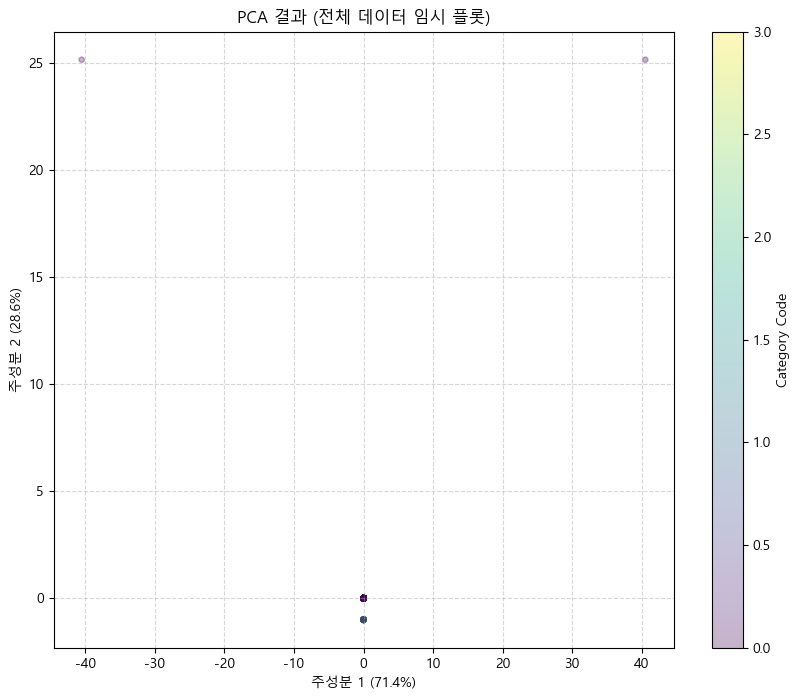

In [8]:
# --- 디버깅용: 임시로 for 루프 대신 전체 데이터를 한 번에 그리기 ---
plt.figure(figsize=(10, 8))
# plt.rc('font', family='Malgun Gothic') # 폰트 설정 필요시 유지
# plt.rcParams['axes.unicode_minus'] = False

# X_pca의 모든 점을 codes를 이용해 색상 구분하여 한번에 그림 (alpha와 s 값 조절)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=codes, cmap='viridis', alpha=0.3, s=15)

plt.xlabel(f"주성분 1 ({explained_variance_ratio[0]*100:.1f}%)")
plt.ylabel(f"주성분 2 ({explained_variance_ratio[1]*100:.1f}%)")
plt.title('PCA 결과 (전체 데이터 임시 플롯)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.colorbar(label='Category Code') # 색상 막대로 범례 표시

plt.show()
# --- 디버깅용 코드 끝 ---

In [9]:
import numpy as np
import pandas as pd

unique_rows, counts = np.unique(X_pca, axis=0, return_counts=True)
print(f"\n고유한 PCA 좌표 개수: {len(unique_rows)}")
# 만약 고유 좌표가 너무 많으면 아래 줄은 주석 처리하거나 상위 몇 개만 출력
print(f"좌표별 포인트 개수 분포 (상위 10개):\n{pd.Series(counts).value_counts().head(10)}")

if len(unique_rows) < 10: # 고유 좌표가 적으면 직접 출력해보기
    print(f"고유 좌표 값 (일부):\n{unique_rows}")


고유한 PCA 좌표 개수: 12
좌표별 포인트 개수 분포 (상위 10개):
1      10
49      1
598     1
Name: count, dtype: int64


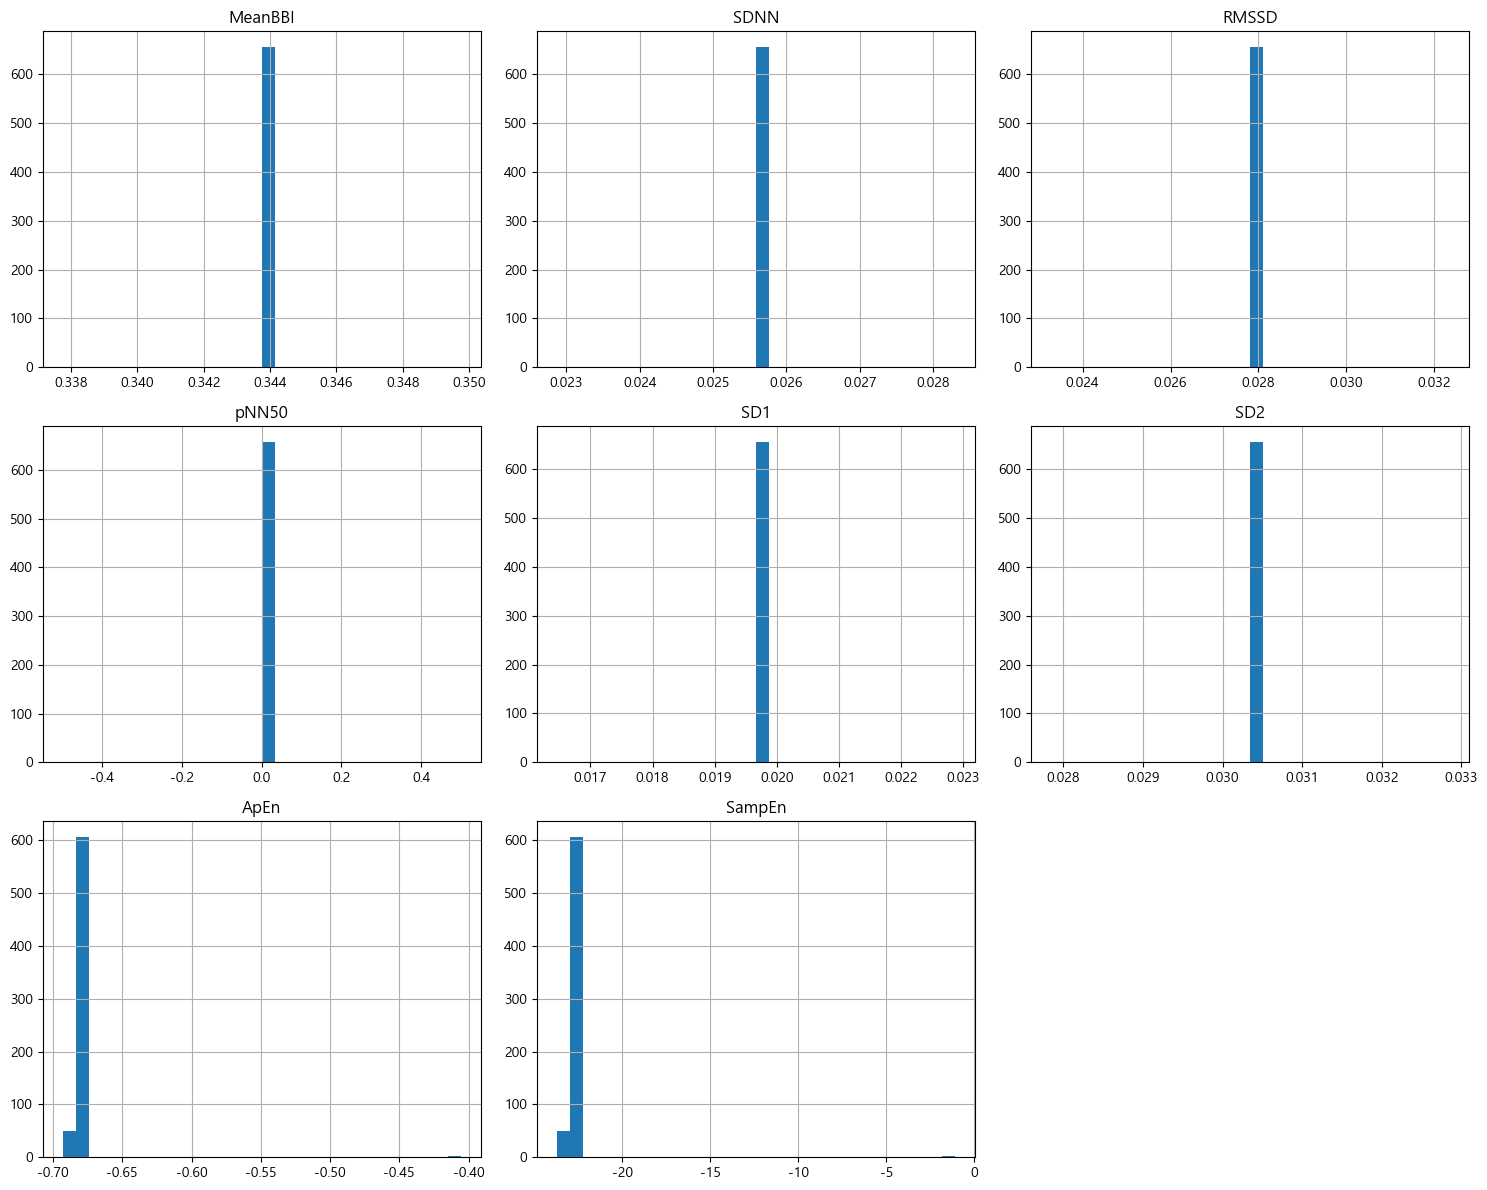

In [10]:
# feat_df의 숫자형 특징 컬럼들의 히스토그램 그리기
feat_df[feature_cols].hist(bins=30, figsize=(15, 12))
plt.tight_layout()
plt.show()

In [11]:
import pandas as pd
import numpy as np

# --- 필수 데이터 (이전 코드에서 계산되었다고 가정) ---
# feat_df: 원본 특징 + 레이블 DataFrame (657 행)
# X_pca: PCA 결과 NumPy 배열 (657, 2)
# label_col: 레이블 컬럼 이름 (예: 'Hypertension')
# categories: 레이블 카테고리 이름 리스트/Index (예: ['Normal', 'Prehypertension', ...])
# ----------------------------------------------------

print("\n" + "="*30)
print(" 레이블별 고유 PCA 좌표 분석 결과")
print("="*30)

# 1. PCA 결과와 레이블을 임시 DataFrame으로 결합
#    feat_df의 인덱스와 X_pca의 순서가 일치해야 합니다.
#    (일반적으로 이전 코드 흐름상 일치합니다)
try:
    pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=feat_df.index) # feat_df와 동일한 인덱스 사용
    pca_df[label_col] = feat_df[label_col]
except ValueError:
    # 인덱스 불일치 시, feat_df 인덱스를 리셋하고 시도 (데이터 순서가 유지되었다고 가정)
    print("경고: feat_df와 X_pca 간 인덱스 불일치 가능성. 인덱스 재설정 후 진행합니다.")
    pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    pca_df[label_col] = feat_df[label_col].values # 값만 복사

# 2. 레이블별로 그룹화
grouped_by_label = pca_df.groupby(label_col)

# 전체 고유 좌표 개수 (참고용)
overall_unique_coords_count = len(np.unique(X_pca, axis=0))
print(f"참고: 전체 데이터의 고유 PCA 좌표 개수 = {overall_unique_coords_count}개\n")


# 3. 각 레이블 그룹에 대해 분석 및 출력
for name, group in grouped_by_label:
    # 카테고리 순서에 맞춰서 출력되도록 categories 리스트 순서 사용 (선택 사항)
    # name = categories[i] 와 같이 루프 돌려도 됨

    print(f"--- 레이블: '{name}' ---")

    # 그룹 내 전체 포인트 수
    total_points_in_group = len(group)
    print(f"  [정보] 이 레이블의 총 포인트 수: {total_points_in_group} 개")

    # 그룹 내 고유한 (PC1, PC2) 좌표의 개수 계산
    # groupby(['PC1', 'PC2']).size()는 각 좌표별 포인트 수를 Series로 반환
    coord_counts_in_group = group.groupby(['PC1', 'PC2'], observed=True).size()
    num_unique_coords = len(coord_counts_in_group) # Series의 길이가 고유 좌표 개수

    print(f"  [결과] 이 레이블 내 고유 PCA 좌표 개수: {num_unique_coords} 개")

    # 해당 레이블 내에서, 각 고유 좌표에 몇 개의 포인트가 겹쳐 있는지 분포 확인
    # coord_counts_in_group 값들의 빈도수를 계산 (예: 1개짜리 좌표가 몇개, 10개짜리 좌표가 몇개 등)
    points_per_coord_distribution = coord_counts_in_group.value_counts().sort_index()

    if num_unique_coords > 0: # 고유 좌표가 있을 경우에만 분포 출력
        print(f"  [분포] 좌표당 포인트 개수 상세:")
        for num_points, count_of_coords in points_per_coord_distribution.items():
            print(f"    - {num_points} 개 포인트가 겹친 좌표 위치: {count_of_coords} 개")
    else:
        print("  [정보] 이 레이블에는 해당하는 데이터 포인트가 없습니다.") # 만약 그룹이 비어있다면

    print("-"*(len(f"--- 레이블: '{name}' ---"))) # 구분선

print("\n분석 완료.")

# --- 선택적 심층 분석: 가장 많이 겹친 좌표들의 레이블 분포 확인 ---
# (겹침의 원인이 특정 레이블에 집중되는지 확인)
# print("\n" + "="*30)
# print(" 참고: 상위 중복 좌표의 레이블 분포")
# print("="*30)
# 전체 데이터에서 좌표별 포인트 수 계산 및 내림차순 정렬
# overall_coord_counts = pca_df.groupby(['PC1', 'PC2'], observed=True).size().sort_values(ascending=False)

# 상위 N개 중복 좌표에 대해 분석 (예: 상위 2개)
# top_n = 2
# for i in range(min(top_n, len(overall_coord_counts))):
#     most_frequent_coord_index = overall_coord_counts.index[i]
#     count = overall_coord_counts.iloc[i]
#     print(f"\n{i+1}번째로 많은 점({count}개)이 겹친 좌표: ({most_frequent_coord_index[0]:.4f}, {most_frequent_coord_index[1]:.4f})")
#     # 해당 좌표를 가진 포인트들의 레이블 분포 확인
#     label_dist_at_coord = pca_df[
#         # 부동소수점 비교 오차를 줄이기 위해 np.isclose 사용 고려 가능
#         (np.isclose(pca_df['PC1'], most_frequent_coord_index[0])) &
#         (np.isclose(pca_df['PC2'], most_frequent_coord_index[1]))
#     ][label_col].value_counts()
#     print("  해당 좌표의 레이블 분포:")
#     print(label_dist_at_coord)
#     print("-" * 20)


 레이블별 고유 PCA 좌표 분석 결과
참고: 전체 데이터의 고유 PCA 좌표 개수 = 12개

--- 레이블: 'Normal' ---
  [정보] 이 레이블의 총 포인트 수: 240 개
  [결과] 이 레이블 내 고유 PCA 좌표 개수: 6 개
  [분포] 좌표당 포인트 개수 상세:
    - 1 개 포인트가 겹친 좌표 위치: 4 개
    - 12 개 포인트가 겹친 좌표 위치: 1 개
    - 224 개 포인트가 겹친 좌표 위치: 1 개
---------------------
--- 레이블: 'Prehypertension' ---
  [정보] 이 레이블의 총 포인트 수: 255 개
  [결과] 이 레이블 내 고유 PCA 좌표 개수: 2 개
  [분포] 좌표당 포인트 개수 상세:
    - 26 개 포인트가 겹친 좌표 위치: 1 개
    - 229 개 포인트가 겹친 좌표 위치: 1 개
------------------------------
--- 레이블: 'Stage 1 hypertension' ---
  [정보] 이 레이블의 총 포인트 수: 102 개
  [결과] 이 레이블 내 고유 PCA 좌표 개수: 2 개
  [분포] 좌표당 포인트 개수 상세:
    - 6 개 포인트가 겹친 좌표 위치: 1 개
    - 96 개 포인트가 겹친 좌표 위치: 1 개
-----------------------------------
--- 레이블: 'Stage 2 hypertension' ---
  [정보] 이 레이블의 총 포인트 수: 60 개
  [결과] 이 레이블 내 고유 PCA 좌표 개수: 8 개
  [분포] 좌표당 포인트 개수 상세:
    - 1 개 포인트가 겹친 좌표 위치: 6 개
    - 5 개 포인트가 겹친 좌표 위치: 1 개
    - 49 개 포인트가 겹친 좌표 위치: 1 개
-----------------------------------

분석 완료.


In [14]:
import pandas as pd
import numpy as np

# --- 필수 데이터 (이전 코드에서 계산되었다고 가정) ---
# pca_df: PCA 좌표(PC1, PC2)와 레이블(label_col)이 있는 DataFrame (예: 657 행)
# label_col: 레이블 컬럼 이름 (예: 'Hypertension')
# ----------------------------------------------------

print("\n" + "="*40)
print(" 각 PCA 좌표 위치별 레이블 분포 상세 분석")
print("="*40)

# 1. PC1, PC2 좌표를 기준으로 그룹화
#    동일한 (PC1, PC2) 값을 가진 행들이 같은 그룹으로 묶입니다.
#    observed=True: 실제로 존재하는 그룹만 고려 (데이터에 없는 카테고리 무시)
try:
    grouped_by_coord = pca_df.groupby(['PC1', 'PC2'], observed=True)
except TypeError: # Pandas 구 버전에서는 observed 옵션 없을 수 있음
    grouped_by_coord = pca_df.groupby(['PC1', 'PC2'])

# 고유한 좌표 위치의 총 개수 확인
num_unique_coordinates = len(grouped_by_coord)
print(f"총 {num_unique_coordinates} 개의 고유한 좌표 위치가 발견되었습니다.")
print("(이전 분석의 '전체 데이터 고유 PCA 좌표 개수'와 일치해야 합니다.)")


# 2. 각 고유 좌표 위치(그룹)에 대해 레이블 분포 계산 및 출력
coord_index = 0 # 좌표 위치 번호 매기기용 카운터
for coord_tuple, group_data in grouped_by_coord:
    coord_index += 1
    pc1_val, pc2_val = coord_tuple # 현재 그룹의 (PC1, PC2) 좌표값 추출
    total_points_at_coord = len(group_data) # 이 좌표에 겹쳐있는 총 포인트 수

    # 현재 좌표 위치 정보 출력
    # 소수점 4자리까지 표시 (필요시 조절)
    print(f"\n--- 좌표 위치 {coord_index}: ({pc1_val:.4f}, {pc2_val:.4f}) ---")
    print(f"  [정보] 이 위치에 겹쳐진 총 포인트 수: {total_points_at_coord} 개")

    # --- 여기가 핵심: 현재 좌표 위치에 있는 데이터들의 레이블 분포 계산 ---
    # group_data (현재 좌표의 모든 포인트) 에서 레이블 컬럼의 값별 개수를 계산
    label_distribution = group_data[label_col].value_counts().sort_index()

    # 레이블 분포 결과 출력
    if not label_distribution.empty:
        print(f"  [분포] 이 위치의 레이블 구성:")
        max_len = max(len(str(label)) for label in label_distribution.index) # 출력 정렬용
        for label_name, count in label_distribution.items():
            # 각 레이블 이름과 해당 레이블의 포인트 개수 출력
            print(f"    - {str(label_name):<{max_len}} : {count} 개")
    else:
        # 이 경우는 거의 발생하지 않음 (group_data가 비어있지 않다면)
        print("  [오류] 이 위치의 레이블 정보를 찾을 수 없습니다.")
    print("-" * (len(f"--- 좌표 위치 {coord_index}: ({pc1_val:.4f}, {pc2_val:.4f}) ---")))


# 최종 검증 (선택 사항)
total_points_summed = sum(len(group) for _, group in grouped_by_coord)
print(f"\n검증: 각 좌표별 포인트 수 합계 = {total_points_summed} (전체 데이터 수와 일치해야 함: {len(pca_df)})")

print("\n분석 완료.")


 각 PCA 좌표 위치별 레이블 분포 상세 분석
총 12 개의 고유한 좌표 위치가 발견되었습니다.
(이전 분석의 '전체 데이터 고유 PCA 좌표 개수'와 일치해야 합니다.)

--- 좌표 위치 1: (-40.5278, 25.1343) ---
  [정보] 이 위치에 겹쳐진 총 포인트 수: 1 개
  [분포] 이 위치의 레이블 구성:
    - Normal : 1 개
------------------------------------

--- 좌표 위치 2: (-0.0000, -1.0054) ---
  [정보] 이 위치에 겹쳐진 총 포인트 수: 1 개
  [분포] 이 위치의 레이블 구성:
    - Stage 2 hypertension : 1 개
-----------------------------------

--- 좌표 위치 3: (-0.0000, -1.0054) ---
  [정보] 이 위치에 겹쳐진 총 포인트 수: 49 개
  [분포] 이 위치의 레이블 구성:
    - Normal               : 12 개
    - Prehypertension      : 26 개
    - Stage 1 hypertension : 6 개
    - Stage 2 hypertension : 5 개
-----------------------------------

--- 좌표 위치 4: (-0.0000, 0.0000) ---
  [정보] 이 위치에 겹쳐진 총 포인트 수: 1 개
  [분포] 이 위치의 레이블 구성:
    - Normal : 1 개
----------------------------------

--- 좌표 위치 5: (-0.0000, 0.0000) ---
  [정보] 이 위치에 겹쳐진 총 포인트 수: 1 개
  [분포] 이 위치의 레이블 구성:
    - Stage 2 hypertension : 1 개
----------------------------------

--- 좌표 위치 6: (-0.0000, 0.0000) ---
  [정보] 이 